# Dependence of plasticity rate on population size

Previous copy-past code became quite cumbersome, can we rescue? 

# Configure workspace

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

# Configure Numpy
np.seterr(all='ignore')
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings("ignore","scipy")
print('Numpy configured')

# Configure Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
matplotlib.rcParams['figure.figsize'] = (TEXTWIDTH, TEXTWIDTH/sqrt(2))
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font' , size   =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes' , titlesize=MEDIUM_SIZE) # fontsize of the axes title
matplotlib.rc('axes' , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rc('lines' , solid_capstyle='round')
plt.rcParams['image.cmap'] = 'parula'
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE,MAUVE])
matplotlib.rc('savefig',dpi=240)
print('Matplotlib configured')

Data location is /home/mer49/Workspace2/PPC_data/
Numpy configured
Matplotlib configured


## Define datasets to examine

In [2]:
use = [(1,[1, 4, 5, 6, 7, 10, 14]),
     (3,[ 1,  2,  4,  6,  7,  8,  9, 10, 11, 12]),
     (3,[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]),
     (4,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
     (5,[6, 7, 8, 9, 10, 11, 12])]

KINEMATICS_TO_PREDICT = [1]

## Fix random seed

Running LMS for random subsets is very expensive. To enable us to re-use the same random subsets on each run of this notebook via caching, we fix the RNG seed. 

In [3]:
np.random.seed(0)

## Define LMS routines 

In [4]:
from ppc_analysis import kininfo,add_constant,polar_error_degrees

# Number of sessions used to initialize LMS
PRETRAIN = 1

# K-fold crossvalidation for same-day predictions
NXVAL    = 10

@memoize
def prepare_data(animal,sessions,predict,PRETRAIN,NXVAL):
    '''
    Retrieve and prepare data for LMS analysis. 
    
    Parameters
    ----------
    animal: int
        Which subject to use
    session: list of ints
        Which session IDs to use
    predit: int
        Which kinematic variable to use. See hte `kininfo` variable.
        0:X, 1:Y, 2:dX, 3:dY, 4: head direction
    PRETRAIN: int
        Number of sessions to train on to initialize LMS
    NXVAL: int
        K-fold crossvalidation
        
    Returns
    -------
    Xtnt: list
        List of neural data for trials for initial trianing. 
        Each trial is NSAMPLES x NNEURONS+1 in shape, where
        a constant feature has been appended to the dF/F 
        Calcium signals. 
    Ytnt: list
        List of kinematic data for trials for initial training. 
    Xtst: list
        Neural data for testing trials.
    Ytst: list
        Kinematic data for testing trials
    sameday: dict
        Dictionary mapping session numbers to
        decoding accuracy results. Relevant Keys are:
            e: the signed decoding errors under crossvalidation
            mabse: the mean absoulte error
            yh: the predicted kinematic values
    '''
    # Get units in common over given sessions
    units,uidxs = get_units_in_common(animal,sessions)
    # Collect pretraining data
    Xtnt = []
    Ytnt = []
    for s in sessions[:PRETRAIN]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        Xtnt += [add_constant(x) for x in extract_in_trial(f,animal,s)]
        Ytnt += extract_in_trial(k,animal,s)
    # Collect testing data
    # Also get single-day performance
    Xtst = []
    Ytst = []
    sameday = {s:{} for s in sessions[PRETRAIN:]}
    for s in sessions[PRETRAIN:]:
        f  = get_dFF(animal,s)[:,units]
        k  = kininfo[predict]['get'](animal,s)
        x  = [add_constant(x) for x in extract_in_trial(f,animal,s)]
        y  = extract_in_trial(k,animal,s)
        Xtst += x
        Ytst += y
        # Also get single-day performance
        yd = trial_crossvalidated_least_squares(x,y,NXVAL,shuffle=True)[1]
        ed = np.concatenate(y) - yd
        ad = mean(abs(ed))
        sameday[s]['e'] = ed
        sameday[s]['mabse'] = ad
        sameday[s]['yh'] = yd
    return Xtnt,Ytnt,Xtst,Ytst,sameday

def run_LMS(X,Y,w0=None,rate=1,reg=1e-16,normalized=False,delta=None,clip=None):
    '''
    Run the LMS algorithm 
    
    Parameters
    ----------
    X: array-like; Nsamples x Nfeatures
        Independent (input) variables
    Y: array-like; Nsamples x Noutputs
        Dependent (output) variables
    
    Other Parameters
    ----------------
    w0: array-like
        Initial parameter weighers
    rate: scalar, default 1
        Learning rate
    reg: scalar, default 1e-12
        L2 regularization penalty to shrink weight
    normalized: bool, default True
        Whether to run the Normalized LMS
    delta: positive scalar, default is None
        (This is not used in the paper.)
        If not `None`, we will report not the true weights
        but the a process that tracks the true rates, with 
        a limit of `delta` change/timestep. In theory,
        this would correspond to a slow process (e.g. 
        synaptic size change), while the actual fast changes
        in synaptic strength are handled by some other 
        process.
    clip: positive scalar, default is None
        If not `None`, then weight changes will be limited
        to be no larger than this value (up to floating point
        accuracy). This is important for enforcing an upper
        bound on the rate of weight change. 

    Returns
    -------
    all_w:
        Weights over time
    all_e;
        Errors over time
    all_yh:
        Predicted kinematics over time
    '''
    X = np.array(X)
    Y = np.array(Y)
    if len(Y.shape)==1:
        Y = array([Y]).T
    rate  = np.float32(rate)
    if not delta is None:
        delta = np.abs(np.float32(delta))
    if not clip  is None:
        clip  = np.abs(np.float32(clip))
    Nsamples   = Y.shape[0]
    Nfeatures  = X.shape[1]
    Nkinematic = Y.shape[1]
    # Initial weights
    w = zeros((Nfeatures,Nkinematic)) if w0 is None\
        else np.array(w0).reshape((Nfeatures,Nkinematic))
    # Tracking weights
    u = w.copy()
    # Store a history of weights, errors, and decoder estiamtes
    all_w  = zeros((Nsamples+1,Nfeatures,Nkinematic))
    all_e  = zeros((Nsamples,Nkinematic))
    all_yh = zeros((Nsamples,Nkinematic))
    all_w[0] = w
    # Shrinkage penalty
    λ = exp(-reg)
    # Run LMS algorithm
    for t in range(Nsamples):
        x    = X[t:t+1] # 1×Nfeat; intput features
        y    = Y[t:t+1] # 1×Nkine; decoded kinematics
        yh   = x @ w    # 1×Nfeat∙Nfeat×Nkine; prediction
        e    = y-yh     # 1×Nkine; errors
        # 1x1; weight update strength (normalized)
        α    = (rate/x @ x.T) if normalized else rate 
        dw   = (α*x.T@ e) # Nfeat×1∙1×Nkine; weight update
        # L2 regularize (not applied to DC parameter)
        dw[:-1] = (w[:-1]+dw[:-1])*λ-w[:-1]
        # Clipped weight updates
        w   += dw if clip is None else np.clip(dw,-clip,clip)
        # Clipped tracking
        u = w if delta is None else u+np.clip(w-u,-delta,delta)
        all_w [t+1] = u
        all_e [t  ] = e
        all_yh[t  ] = yh
        if not clip is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=clip*(1+1e-7)))
        if not delta is None:
            assert(np.all(np.abs(all_w[t+1]-all_w[t])<=delta*(1+1e-7)))
    if not delta is None:
        all_yh = np.sum(X[:,:,None] * all_w[:-1],axis=1)
        all_e  = Y - all_yh
    all_w = all_w[1:]

    return all_w,all_e,all_yh

def summarize_LMS_result(animal,sessions,result,verbose=True):
    '''
    Expects a `result` dictionary with the keys `w`, `ec`, `e`, `y`, and `e0`
    '''
    slens, edges           = get_session_lengths(animal,sessions,PRETRAIN)
    weights                = result['w']
    end_of_session_weights = weights[edges,:-1] #exclude constant weight
    inter_session_Δweights = diff(end_of_session_weights,axis=0)
    days                   = [daymap[animal,s] for s in sessions]
    Δdays                  = diff(days)[PRETRAIN-1:]
    Δweight_per_Δday       = inter_session_Δweights/Δdays[:,None]
    MABS_Δw_per_Δday       = mean(abs(Δweight_per_Δday))
    MABSW                  = mean(abs(weights))
    MABS_Δw_pct_per_day    = mean(MABS_Δw_per_Δday)/MABSW*100
    ec = mean(abs(result['ec']))
    er = mean(abs(result['e']))
    
    variance  = var(result['y'])
    residuals = var(result['e'])
    explained = variance-residuals
    pctΔvlms  = 100*explained/variance
    
    variance  = var(result['y'])
    residuals = var(result['ec'])
    explained = variance-residuals
    pctΔvcat  = 100*explained/variance
    
    variance  = var(result['y'])
    residuals = var(result['e0'])
    explained = variance-residuals
    pctΔvfix  = 100*explained/variance
    
    if not pctΔvcat>pctΔvfix:
        raise ValueError('Expected concat. performance to be better than no learning?')
    
    if abs(pctΔvlms-pctΔvfix)/pctΔvfix<1e-6:
        relperf = 0
    else:
        relperf = (pctΔvlms-pctΔvfix)/(pctΔvcat-pctΔvfix)*100
        
    if verbose:
        print('Mouse %s sessions %s'%(animal,sessions))
        print(' Average change is %0.2f%% per day'%MABS_Δw_pct_per_day)
        print(' Concatenated error level is %2f'%ec)
        print(' LMS          error level is %2f'%er)
        print(' %% explained variance %0.2f LMS'%pctΔvlms)
        print(' %% explained variance %0.2f Concat.'%pctΔvcat)
        print(' %% explained variance %0.2f Fixed'%pctΔvfix)
        print(' Relative performance %0.2f%%'%relperf)
    return relperf,MABS_Δw_pct_per_day

@memoize
def get_LMS_pretraining(animal,sessions,predict,PRETRAIN,NXVAL):
    # Get data
    print('Retrieving data...')
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    print('Running pretraining and concatenated tests...')
    # Concatenated baseline
    wc,yc,_ = trial_crossvalidated_least_squares(Xtst,Ytst,NXVAL,shuffle=True)
    e = Ytest - yc
    ec2,ec1 = polar_error_degrees(Ytest,yc) if polar_error else\
                  np.sqrt(np.mean(np.abs(e)**2)),np.mean(np.abs(e))
    # Pretraining error baseline and initial weights
    w0 = reglstsq(Xtrain,Ytrain)
    yh = (Xtest @ w0).reshape(Ytest.shape)
    e  = Ytest - yh
    e02,e01 = polar_error_degrees(Ytest,yh) if polar_error else\
                  np.sqrt(np.mean(np.abs(e)**2)),np.mean(np.abs(e))
    return Xtrain,Ytrain,Xtest,Ytest,w0,e01,e02,wc,ec1,ec2

# Need to get duration (in samples) of each session
@memoize
def get_session_lengths(animal,sessions,PRETRAIN):
    slens = [len(concatenate(extract_in_trial(get_dFF(animal,s)[:,0],animal,s))) for s in sessions]
    edges = array([0]+list(cumsum(slens[PRETRAIN:])-2))
    return slens, edges

Defined subroutines
Defined LMS algorithm


# Binary search unit subset with limits for optimizing learning rate

In [5]:
@memoize
def get_plasticity_level(animal,
                         sessions,
                         units,
                         minrate=1e-6,
                         maxrate=1e-2,
                         ERLEVEL=99,
                         PRETRAIN=1,
                         NXVAL=10):
    
    # Get data
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    
    # Identify target accuracy level: from concatenated performance
    wc,yc,_ = trial_crossvalidated_least_squares([xi[:,units] for xi in Xtst],Ytst,NXVAL,shuffle=True)
    ec = Ytest - yc
    MABSEC = mean(abs(ec))

    # Identify initial weights and error without more learning:
    w0 = reglstsq(Xtrain[:,units],Ytrain)
    yh = (Xtest[:,units] @ w0).reshape(Ytest.shape)
    e0  = Ytest - yh
    MABSE0 = mean(abs(e0))

    # Set target level: 
    ETARGET = (ERLEVEL*MABSEC + (100-ERLEVEL)*MABSE0)/100

    def get_lms_for_rate(rate):
        # Small subroutine
        w,e,yh = run_LMS(Xtest[:,units],Ytest,w0,rate=rate)
        return {
            'y' :Ytest,
            'e0':e0,
            'ec':ec,
            'w' :w.squeeze(),
            'e' :e.squeeze(),
            'yh':yh.squeeze()}

    # Start with getting weight change at max/min learning rates
    performances = {}
    result = get_lms_for_rate(minrate)
    performances[minrate]=summarize_LMS_result(animal,sessions,result,verbose=False)[0]
    result = get_lms_for_rate(maxrate)
    performances[maxrate]=summarize_LMS_result(animal,sessions,result,verbose=False)[0]

    # Binary search to match target performance
    lower_rate = minrate
    upper_rate = maxrate
    while True:
        # Identify pivot
        perfs = [performances[lower_rate],performances[upper_rate]]
        rates = log(array([lower_rate,upper_rate]))
        rate  = exp(interp1d(perfs,rates)(ERLEVEL))
        # Test pivot
        result = get_lms_for_rate(rate)
        rperf,MABS_Δw_pct_per_day=summarize_LMS_result(animal,sessions,result,verbose=False)
        performances[rate]=rperf
        # Check convergence 
        if rperf>ERLEVEL and (rperf-ERLEVEL)/ERLEVEL<TOL: break
        # Update limits and iterate
        if rperf<ERLEVEL: lower_rate = rate
        else:             upper_rate = rate

    # Get summary rate of weight change
    return MABS_Δw_pct_per_day,MABSE0,MABSEC,mean(abs(result['e']))

In [6]:
animal, sessions = use[4]
PRETRAIN  = 1
NXVAL     = 10
clipΔ     = None
predict   = 1 # 1 is Y position
ERLEVEL   = 99
TOL       = 1e-3
Nreplicas = 10
Nnunits   = 7

print('Mouse',animal)
print('Sessions',sessions)

# Load data
Xtrain,Ytrain,Xtest,Ytest,w0,e01,e02,wc,ec1,ec2 =\
    get_LMS_pretraining(animal,sessions,predict,PRETRAIN,NXVAL)

# Define unit sets to check
Nneurons  = Xtest.shape[1]-1
print('Testing subsets of %d neurons'%Nneurons)
Ntest     = array(sorted(list(set(int32(2**linspace(-2,0,Nnunits)*Nneurons)))))
unit_sets = []
for unit_number in Ntest[:-1]:
    for replica in range(Nreplicas):
        # Use random subset of neurons
        use_features = sorted(np.random.choice(arange(Nneurons),unit_number,replace=False))
        # always include the constant feature
        use_features = cat([use_features,[Nneurons]])
        unit_sets.append(use_features)
        
units = unit_sets[15]
print(get_plasticity_level(animal,sessions,units))

jobs = [(animal,sessions,units) for units in unit_sets]
def helper(p):
    i,p = p
    return i,get_plasticity_level(*p)
reset_pool()

Δws = parmap(helper,enumerate(jobs))

Mouse 5
Sessions [6, 7, 8, 9, 10, 11, 12]
Testing subsets of 112 neurons
(23.636202226991205, 1.570493979823696, 0.9851579314819132, 0.9885110056379267)
[##################################################]100.0% 


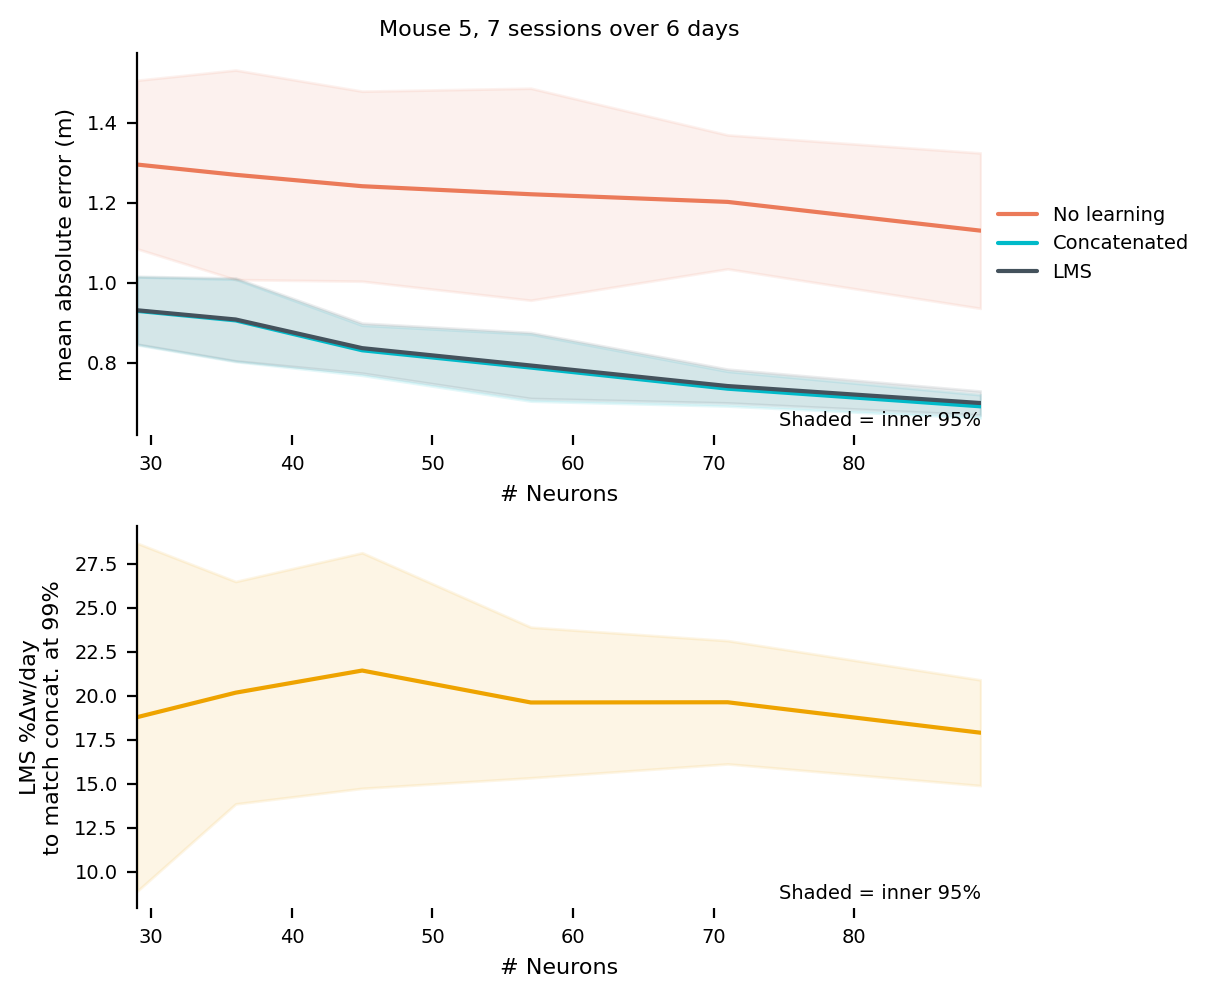

In [7]:
counts = defaultdict(list)
for u,Δw in zip(unit_sets,Δws):
    counts[len(u)].append(Δw)
n     = sorted(list(counts.keys()))
μ     = array([      mean(counts[k],axis=0)      for k in n]).T
σ     = array([       std(counts[k],axis=0)      for k in n]).T
p2p5  = array([percentile(counts[k], 2.5,axis=0) for k in n]).T
p97p5 = array([percentile(counts[k],97.5,axis=0) for k in n]).T
days  = [daymap[animal,s] for s in sessions]

figure(figsize=(6,5))
subplot(211)

c=RUST; j=1
fill_between(n,μ[j]-1.96*σ[j],μ[j]+1.96*σ[j],alpha=0.1,color=c)
plot(n,μ[j],color=c,label='No learning')

c=TURQUOISE; j=2
fill_between(n,μ[j]-1.96*σ[j],μ[j]+1.96*σ[j],alpha=0.1,color=c)
plot(n,μ[j],color=c,label='Concatenated')

c=BLACK; j=3
fill_between(n,μ[j]-1.96*σ[j],μ[j]+1.96*σ[j],alpha=0.1,color=c)
plot(n,μ[j],color=c,label='LMS')

rightlegend()
simpleraxis()
ylabel('mean absolute error (m)')
xlabel('# Neurons')
text(xlim()[1],ylim()[0]+pixels_to_yunits(5),'Shaded = inner 95%',
    ha='right',
    va='bottom')
title('Mouse %d, %d sessions over %d days'%(animal,len(sessions),days[-1]-days[0]))

subplot(212)

c = OCHRE
fill_between(n,μ[0]-1.96*σ[0],μ[0]+1.96*σ[0],alpha=0.1,color=c)
#fill_between(n,p2p5,p97p5,alpha=0.2,color=c,lw=0)
plot(n,μ[0],color=c)

simpleraxis()
ylabel('LMS %Δw/day\nto match concat. at 99%')
xlabel('# Neurons')
text(xlim()[1],ylim()[0]+pixels_to_yunits(5),'Shaded = inner 95%',
    ha='right',
    va='bottom')

tight_layout()

savefigure('LMS_weight_change_population_size_m%d_ss%d-%d'%(animal,sessions[0],sessions[-1]))

# Repeat with fixed error level

Identify learning rate required by binary search

In [8]:
@memoize
def get_plasticity_level_fixed(animal,
                         sessions,
                         units,
                         FIXED_ERROR,
                         minrate  = 1e-6,
                         maxrate  = 1e-2,
                         reg      = 1e-5,
                         PRETRAIN = 1,
                         NXVAL    = 10,
                         verbose  = False):
    
    # Get data
    Xtnt,Ytnt,Xtst,Ytst,samedayperf = prepare_data(animal,sessions,predict,PRETRAIN,NXVAL)
    Xtrain = concatenate(Xtnt)
    Ytrain = concatenate(Ytnt)
    Xtest  = concatenate(Xtst)
    Ytest  = concatenate(Ytst)
    
    # Argument checking
    minrate = array(minrate).ravel()[0]
    maxrate = array(maxrate).ravel()[0]
    
    # Identify target accuracy level: from concatenated performance
    wc,yc,_ = trial_crossvalidated_least_squares([xi[:,units] for xi in Xtst],Ytst,NXVAL,shuffle=True)
    ec = Ytest - yc
    MABSEC = mean(abs(ec))

    # Identify initial weights and error without more learning:
    w0 = reglstsq(Xtrain[:,units],Ytrain)
    yh = (Xtest[:,units] @ w0).reshape(Ytest.shape)
    e0  = Ytest - yh
    MABSE0 = mean(abs(e0))

    def get_mabse_for_rate(rate):
        # Small subroutine
        try:
            w,e,yh = run_LMS(Xtest[:,units],Ytest,w0,rate=rate,reg=reg)
            #return mean(abs(e))
            #Expects a `result` dictionary with the keys `w`, `ec`, `e`, `y`, and `e0`
            return {
                'MABSE':mean(abs(e)),
                'y' :Ytest,
                'e0':e0,
                'ec':ec,
                'w' :w.squeeze(),
                'e' :e.squeeze(),
                'yh':yh.squeeze()}
        except FloatingPointError:
            # Return something unreasonably large
            #return mean(abs(Ytest))*10
            w  = np.repeat(w0,len(Ytest))
            yh = mean(Ytest)*np.ones(Ytest.shape)
            e  = Ytest-yh
            return {
                'MABSE':np.nan,
                'y' :Ytest,
                'e0':e0,
                'ec':ec,
                'w' :w.squeeze(),
                'e' :e.squeeze(),
                'yh':yh.squeeze()}
    
    #Find fastest stable learning rate
    Σ = (Xtest[:,units].T @ Xtest[:,units])/ Xtest.shape[0]
    e,v = psd_eig(Σ)
    λmax = np.max(abs(e))
    λmaxrate = 2/λmax
    
    if maxrate>λmaxrate:
        warnings.warn('Max. learning rate is unstable')
    
    # Start with getting weight change at max/min learning rates
    performances = {}
    performances[minrate] = get_mabse_for_rate(minrate)['MABSE']
    performances[maxrate] = get_mabse_for_rate(maxrate)['MABSE']
    
    # Binary search to match target performance
    lower_rate = minrate
    upper_rate = maxrate
    while True:
        # Identify pivot
        perfs = [performances[lower_rate],performances[upper_rate]]
        rates = log(array([lower_rate,upper_rate])).ravel()
        if verbose:
            print(perfs)
            print(rates)
        if any(np.isnan(perfs)):
            rate = exp(mean(rates))
            warnings.warn('Undefined performance at one limit, using midpoint')
        else:
            if FIXED_ERROR<min(perfs):
                warnings.warn('Cannot achieve desired error level')
                return np.NaN,MABSE0,MABSEC,np.NaN
            if FIXED_ERROR>max(perfs):
                warnings.warn('Required error level is unrealistically large')
                return np.NaN,MABSE0,MABSEC,np.NaN
            rate  = exp(interp1d(perfs,rates)(FIXED_ERROR))
        # Test pivot
        result = get_mabse_for_rate(rate)
        MABSE = result['MABSE']
        performances[rate] = MABSE
        
        # Check convergence, update limits and iterate
        if MABSE>FIXED_ERROR and (MABSE-FIXED_ERROR)/FIXED_ERROR<TOL: break
        if MABSE>FIXED_ERROR: lower_rate = rate
        else:                 upper_rate = rate
        
    #Expects a `result` dictionary with the keys `w`, `ec`, `e`, `y`, and `e0`
    rperf,MABS_Δw_pct_per_day=summarize_LMS_result(animal,sessions,result,verbose=False)
    # Get summary rate of weight change
    return MABS_Δw_pct_per_day,MABSE0,MABSEC,MABSE

In [ ]:
animal, sessions = use[1]
print('Mouse'   ,animal  )
print('Sessions',sessions)

PRETRAIN  = 1
NXVAL     = 10
clipΔ     = None
predict   = 1
TOL       = 1e-3
Nreplicas = 50
Nnunits   = 20
MINRATE   = 1e-9
MAXRATE   = 1e0
refrate   = 4e-4

# Load data and run reference LMS to get target error
Xtrain,Ytrain,Xtest,Ytest,w0,e01,e02,wc,ec1,ec2 =\
    get_LMS_pretraining(animal,sessions,predict,PRETRAIN,NXVAL)
w,e,yh = run_LMS(Xtest,Ytest,w0=w0,rate=refrate,normalized=False,delta=None,clip=None)

#TARGET_ERROR = 0.7 # meters
TARGET_ERROR = mean(abs(e))
print('Target error level is',TARGET_ERROR)


# Define unit sets to check
Nneurons  = Xtest.shape[1]-1
print('Testing subsets of %d neurons'%Nneurons)
Ntest     = array(sorted(list(set(int32(2**linspace(-2,0,Nnunits)*Nneurons)))))
unit_sets = []
for unit_number in Ntest[:-1]:
    for replica in range(Nreplicas):
        # Use random subset of neurons
        use_features = sorted(np.random.choice(arange(Nneurons),unit_number,replace=False))
        # always include the constant feature
        use_features = cat([use_features,[Nneurons]])
        unit_sets.append(use_features)
# Include set of all neurons once
unit_sets.append(arange(Nneurons+1))

jobs = [(animal,sessions,units) for units in unit_sets]
def helper(p):
    i,p = p
    try:
        return i,get_plasticity_level_fixed(*(p+(TARGET_ERROR,)))#,MINRATE,MAXRATE)))
    except FloatingPointError:
        warnings.warn('LMS numerical error')
        traceback.print_exc()
        return i,(np.NaN,np.NaN,np.NaN,np.NaN)
        
reset_pool()

print('Runinng sanity check..')
index = -5
job = jobs[index]
animal,sessions,units = job
print(get_plasticity_level_fixed(animal,sessions,units,TARGET_ERROR))
print(get_plasticity_level_fixed(animal,sessions,units,TARGET_ERROR,MINRATE,MAXRATE))
print(helper((0,job)))

Δws = parmap(helper,enumerate(jobs),debug=False)

Mouse 3
Sessions [1, 2, 4, 6, 7, 8, 9, 10, 11, 12]
Target error level is 0.6816910017362134
Testing subsets of 114 neurons


In [ ]:
warnings.filterwarnings("ignore",category=RuntimeWarning)

counts = defaultdict(list)
for (a,ss,u),Δw in zip(jobs,Δws):
    counts[len(u)].append(Δw)
n     = sorted(list(counts.keys()))
μ     = array([   nanmean(counts[k],axis=0)      for k in n]).T
σ     = array([    nanstd(counts[k],axis=0)      for k in n]).T
days  = [daymap[animal,s] for s in sessions]

figure(figsize=(TEXTWIDTH,TEXTWIDTH/3))

subplot(121)
c=TURQUOISE; j=2
fill_between(n,μ[j]-1.96*σ[j],μ[j]+1.96*σ[j],alpha=0.1,color=c)
plot(n,μ[j],color=c,label='Concatenated')
c=RUST; j=1
fill_between(n,μ[j]-1.96*σ[j],μ[j]+1.96*σ[j],alpha=0.1,color=c)
plot(n,μ[j],color=c,label='$1^{\operatorname{st}}$ day weights')
simpleraxis()
ylabel('Mean absolute\nerror (m)')
xlabel('# Neurons')
xlim(Nneurons//2,Nneurons)
l = legend()
l.get_frame().set_alpha(0)
nicex()
title('Error levels')

subplot(122)
c = OCHRE
fill_between(n,μ[0]-1.96*σ[0],μ[0]+1.96*σ[0],alpha=0.1,color=c)
plot(n,μ[0],color=c)
simpleraxis()
ylabel('LMS %%Δw/day\nTarget error %0.2f m'%TARGET_ERROR)
xlabel('# Neurons')
text(xlim()[1],ylim()[1]-pixels_to_yunits(35),'Shaded = inner 95%\nover unit subsets',
    ha='right',
    va='top')
xlim(Nneurons//2,Nneurons)
nicex()
title('Plasticity rate')


tight_layout()
subplots_adjust(top=0.75,wspace=0.6,right=0.75)
text(xlim()[1]+pixels_to_xunits(30),mean(ylim()),
     'Mouse %d\n%d sessions\nover %d days'%(animal,len(sessions),days[-1]-days[0]),
    ha='left',
    va='center',
    fontsize=BIGGER_SIZE)

savefigure('LMS_weight_change_population_size_m%d_ss%d-%d_2'%(animal,sessions[0],sessions[-1]))

In [ ]:
c = OCHRE
fill_between(n,μ[0]-1.96*σ[0],μ[0]+1.96*σ[0],alpha=0.1,color=c)
plot(n,μ[0],color=c)
simpleraxis()
ylabel('LMS %%Δw/day\nTarget error %0.2f m'%TARGET_ERROR)
xlabel('# Neurons')
text(xlim()[1],ylim()[1]-pixels_to_yunits(35),'Shaded = inner 95%\nover unit subsets',
    ha='right',
    va='top')
xlim(Nneurons//2,Nneurons)
nicex()
title('Plasticity rate')